Tutorial: Ply tailoring using GA for a simply-supported plate normal load
==
Date: 4 February 2026

Author: Saullo G. P. Castro

Cite this tutorial as:

Saullo G. P. Castro. (2025). General-purpose finite element solver based on Python and Cython (Version 0.6.2). Zenodo. DOI: https://doi.org/10.5281/zenodo.6573489.

Installing required modules
--

In [1]:
!python -m pip install numpy pyvista pymoo scipy pyfe3d > tmp.txt

DEPRECATION: Loading egg at /Users/saullogiovanip/miniconda3/lib/python3.13/site-packages/panels-0.5.0-py3.13-macosx-11.1-arm64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/saullogiovanip/miniconda3/lib/python3.13/site-packages/tuduam-2026.3-py3.13.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
import numpy as np
import pyvista as pv
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.callback import Callback
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.termination import get_termination
from scipy.sparse.linalg import spsolve
from scipy.sparse import coo_matrix
from pyfe3d.shellprop import ShellProp
from pyfe3d import Quad4, Quad4Data, Quad4Probe, INT, DOUBLE, DOF


def get_Q_matrix(E1, E2, nu12, G12, G13, G23, theta_deg):
    """
    Calculate the transformed reduced stiffness matrix Q_bar for a given angle.
    """
    nu21 = nu12 * E2 / E1
    denom = 1 - nu12 * nu21
    Q11 = E1 / denom
    Q22 = E2 / denom
    Q12 = nu12 * E2 / denom
    Q66 = G12

    c = np.cos(np.radians(theta_deg))
    s = np.sin(np.radians(theta_deg))

    c2 = c**2; s2 = s**2; c4 = c**4; s4 = s**4

    Q_bar_11 = Q11*c4 + 2*(Q12 + 2*Q66)*s2*c2 + Q22*s4
    Q_bar_22 = Q11*s4 + 2*(Q12 + 2*Q66)*s2*c2 + Q22*c4
    Q_bar_12 = (Q11 + Q22 - 4*Q66)*s2*c2 + Q12*(s4 + c4)
    Q_bar_66 = (Q11 + Q22 - 2*Q12 - 2*Q66)*s2*c2 + Q66*(s4 + c4)

    Q_bar_44 = G23 * c2 + G13 * s2
    Q_bar_55 = G13 * c2 + G23 * s2
    Q_bar_45 = (G13 - G23) * c * s

    Q_bar = np.array([
        [Q_bar_11, Q_bar_12, 0, 0, 0, 0],
        [Q_bar_12, Q_bar_22, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, Q_bar_44, Q_bar_45, 0],
        [0, 0, 0, Q_bar_45, Q_bar_55, 0],
        [0, 0, 0, 0, 0, Q_bar_66]
    ])
    return Q_bar


class SmearedPlateOptimization(ElementwiseProblem):
    def __init__(self, nx, ny, a, b, load_val, max_deflection, thicknesses, mat_data):
        self.nx = nx
        self.ny = ny
        self.n_elems = (self.nx - 1)*(self.ny - 1)
        self.a = a
        self.b = b
        self.load_val = load_val
        self.max_deflection = max_deflection
        self.rho = mat_data['rho']

        # Pre-calculate Base Q matrices
        E1, E2 = mat_data['E1'], mat_data['E2']
        nu12, G12 = mat_data['nu12'], mat_data['G12']
        G13, G23 = mat_data['G13'], mat_data['G23']

        num_orientations = 3

        self.Q0 = get_Q_matrix(E1, E2, nu12, G12, G13, G23, 0)
        self.Q90 = get_Q_matrix(E1, E2, nu12, G12, G13, G23, 90)
        self.Q45p = get_Q_matrix(E1, E2, nu12, G12, G13, G23, 45)
        self.Q45m = get_Q_matrix(E1, E2, nu12, G12, G13, G23, -45)
        self.Q45_sum = self.Q45p + self.Q45m

        self.thicknesses = thicknesses
        self.eid_prop = {}

        n_var = num_orientations*self.n_elems

        self._init_fe_model()

        super().__init__(n_var=n_var,
                         n_obj=1,
                         n_ieq_constr=1,
                         xl=0,
                         xu=len(thicknesses) - 1,
                         vtype=int)


    def _init_fe_model(self):
        data = Quad4Data()
        probe = Quad4Probe()

        xtmp = np.linspace(0, self.a/2, self.nx)
        ytmp = np.linspace(0, self.b/2, self.ny)
        xmesh, ymesh = np.meshgrid(xtmp, ytmp)
        ncoords = np.vstack((xmesh.T.flatten(), ymesh.T.flatten(), np.zeros_like(ymesh.T.flatten()))).T
        self.ncoords = ncoords
        x = ncoords[:, 0]
        y = ncoords[:, 1]
        z = ncoords[:, 2]
        ncoords_flatten = ncoords.flatten()
        self.ncoords_flatten = ncoords_flatten

        nids = 1 + np.arange(ncoords.shape[0])
        nid_pos = dict(zip(nids, np.arange(len(nids))))
        nids_mesh = nids.reshape(self.nx, self.ny)
        n1s = nids_mesh[:-1, :-1].flatten()
        n2s = nids_mesh[1:, :-1].flatten()
        n3s = nids_mesh[1:, 1:].flatten()
        n4s = nids_mesh[:-1, 1:].flatten()

        num_elements = len(n1s)

        self.KC0r = np.zeros(data.KC0_SPARSE_SIZE*num_elements, dtype=INT)
        self.KC0c = np.zeros(data.KC0_SPARSE_SIZE*num_elements, dtype=INT)
        self.KC0v = np.zeros(data.KC0_SPARSE_SIZE*num_elements, dtype=DOUBLE)
        self.N = DOF*self.nx*self.ny

        self.quads = []
        init_k_KC0 = 0
        eid = -1
        for n1, n2, n3, n4 in zip(n1s, n2s, n3s, n4s):
            #NOTE dummy property
            prop = ShellProp()
            prop.scf_k13 = 5/6.
            prop.scf_k23 = 5/6.
            eid += 1
            self.eid_prop[eid] = prop

            pos1 = nid_pos[n1]
            pos2 = nid_pos[n2]
            pos3 = nid_pos[n3]
            pos4 = nid_pos[n4]
            r1 = ncoords[pos1]
            r2 = ncoords[pos2]
            r3 = ncoords[pos3]
            normal = np.cross(r2 - r1, r3 - r2)[2]
            assert normal > 0
            quad = Quad4(probe)
            quad.eid = eid
            quad.n1 = n1
            quad.n2 = n2
            quad.n3 = n3
            quad.n4 = n4
            quad.c1 = DOF*nid_pos[n1]
            quad.c2 = DOF*nid_pos[n2]
            quad.c3 = DOF*nid_pos[n3]
            quad.c4 = DOF*nid_pos[n4]
            quad.init_k_KC0 = init_k_KC0
            quad.update_rotation_matrix(ncoords_flatten)
            quad.update_probe_xe(ncoords_flatten)
            quad.update_KC0(self.KC0r, self.KC0c, self.KC0v, prop)
            self.quads.append(quad)
            init_k_KC0 += data.KC0_SPARSE_SIZE

    def _evaluate(self, var, out, *args, **kwargs):
        total_volume = 0.0

        #NOTE important line below to zero the sparse matrix container
        self.KC0v *= 0

        for i, quad in enumerate(self.quads):
            prop = self.eid_prop[quad.eid]

            h0 = self.thicknesses[var[3*i]]
            h45 = self.thicknesses[var[3*i + 1]]
            h90 = self.thicknesses[var[3*i + 2]]
            h_total = h0 + 2*h45 + h90

            # Smeared Stiffness Calculation
            A = (h0 * self.Q0) + (h90 * self.Q90) + (h45 * self.Q45_sum)
            D = (h_total**2 / 12.0) * A

            # NOTE using the full Voigt notation indices
            # membrane stiffness
            prop.A11 = A[0, 0]
            prop.A12 = A[0, 1]
            prop.A22 = A[1, 1]
            prop.A66 = A[5, 5]

            # transverse shear stiffness, the SCF is applied in pyfe3d
            prop.E44 = A[3, 3]
            prop.E45 = A[3, 4]
            prop.E55 = A[4, 4]

            # bending stiffness
            prop.D11 = D[0, 0]
            prop.D12 = D[0, 1]
            prop.D22 = D[1, 1]
            prop.D66 = D[5, 5]

            prop.h = h_total

            quad.update_probe_xe(self.ncoords_flatten)
            quad.update_KC0(self.KC0r, self.KC0c, self.KC0v, prop, update_KC0v_only=1)

            total_volume += quad.area * h_total

        KC0 = coo_matrix((self.KC0v, (self.KC0r, self.KC0c)), shape=(self.N, self.N)).tocsc()

        bk = np.zeros(self.N, dtype=bool)

        x = self.ncoords[:, 0]
        y = self.ncoords[:, 1]
        z = self.ncoords[:, 2]

        # removing in-plane motion
        bk[0::DOF] = True #NOTE u displacements
        bk[1::DOF] = True #NOTE v displacements

        at_edges = np.isclose(x, 0.) | np.isclose(y, 0.)
        bk[2::DOF][at_edges] = True #NOTE w displacements

        at_sym_along_x = np.isclose(x, self.a/2)
        bk[5::DOF][at_sym_along_x] = True

        at_sym_along_y = np.isclose(y, self.b/2)
        bk[4::DOF][at_sym_along_y] = True

        bu = ~bk

        # point load at center node
        fext = np.zeros(self.N)
        fmid = self.load_val
        check = np.isclose(x, self.a/2) & np.isclose(y, self.b/2)
        fext[2::DOF][check] = fmid

        KC0uu = KC0[bu, :][:, bu]

        # checking load balance
        assert fext[bu].sum() == fmid

        # solving the static system
        uu = spsolve(KC0uu, fext[bu])

        u = np.zeros(self.N)
        u[bu] = uu

        # reading the deflections in the z direction
        w = u[2::DOF].reshape(self.nx, self.ny).T

        self.result_w = u[2::DOF]

        # reading the maximum absolute deflection
        w_max = np.max(np.abs(w))

        out["F"] = total_volume
        out["G"] = [w_max/self.max_deflection - 1]


class HistorySaver(Callback):
    def __init__(self):
        super().__init__()
        self.n_evals = []
        self.F = []  # Objective History
        self.G = []  # Constraint History
        self.best_X = None # Store the best design variables here
        self.best_F = None # Store best mass
        self.best_G = None # Store best constraint

    def notify(self, algorithm):
        # Access the "optimum" (best individuals found so far)
        if len(algorithm.opt) > 0:
            best_ind = algorithm.opt[0]

            # Save history for plotting
            self.n_evals.append(algorithm.evaluator.n_eval)
            self.F.append(best_ind.F[0])

            g_val = best_ind.G[0] if best_ind.G is not None else 0.0
            self.G.append(g_val)

            # Save the specific values for the final result
            # We use .copy() because X is a numpy array and we want the snapshot
            self.best_X = best_ind.X.copy()
            self.best_F = best_ind.F[0]
            self.best_G = g_val


In [3]:
if __name__ == "__main__":
    # Material Data (Carbon/Epoxy approx)
    mat_data = {
        'E1': 140e9,
        'E2': 10e9,
        'nu12': 0.3,
        'G12': 5e9,
        'G13': 5e9,
        'G23': 5e9,
        'rho': 1600.0
    }

    # Problem definition

    # allowed discrete thickness values
    thicknesses = 0.125*1e-3*np.arange(1, 21)

    problem = SmearedPlateOptimization(
        nx=11, ny=6,
        a=2.0, b=1.0,
        load_val=80.0,
        max_deflection=0.001,
        thicknesses=thicknesses,
        mat_data=mat_data
    )

    # Genetic Algorithm Setup
    # NOTE about the eta parameter
    #         a low value (e.g., 2–5) creates a more flat and wide distribution, favours exploration: Offspring can be very far from parents.
    #         a high value (e.g., 20–30) creates a taller and narrower distribution, favours exploitation: Offspring stay very close to parents.
    algorithm = GA(
        pop_size=200,
        sampling=IntegerRandomSampling(),
        crossover=SBX(prob=1.0, eta=2, repair=RoundingRepair()),
        mutation=PM(prob=0.1, eta=10, repair=RoundingRepair()),
        eliminate_duplicates=True
    )

    # Termination criteria
    termination = get_termination("n_gen", 100)

    history = HistorySaver()

    # Execute
    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=7,
                   verbose=True,
                   save_history=False,
                   callback=history)

    print("Optimization Complete.")
    print(f"Best Mass: {history.best_F:.4f} kg")
    print(f"Max Deflection: {(history.best_G + 1)*problem.max_deflection:.4e}")
    print(f"Max Deflection constraint violation: {history.best_G:.4e}")

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |      200 |  0.3074207616 |  0.9498645000 |             - |             -
     2 |      400 |  0.3074207616 |  0.6819816624 |             - |             -
     3 |      600 |  0.2718360156 |  0.5820539527 |             - |             -
     4 |      800 |  0.2524409595 |  0.5028083060 |             - |             -
     5 |     1000 |  0.2423526994 |  0.4302689021 |             - |             -
     6 |     1200 |  0.1309755566 |  0.3666742314 |             - |             -
     7 |     1400 |  0.1079086246 |  0.3164371509 |             - |             -
     8 |     1600 |  0.1051699700 |  0.2683484572 |             - |             -
     9 |     1800 |  0.0858380415 |  0.2314240666 |             - |             -
    10 |     2000 |  0.0546235208 |  0.1976557083 |             - |             -
    11 |     2200 |  0.000000E+00 |  0.1674253846 |  0.0030475000 |  0.0030475000
    12 |     240

/Users/saullogiovanip/miniconda3/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/saullogiovanip/miniconda3/lib/python3.13/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


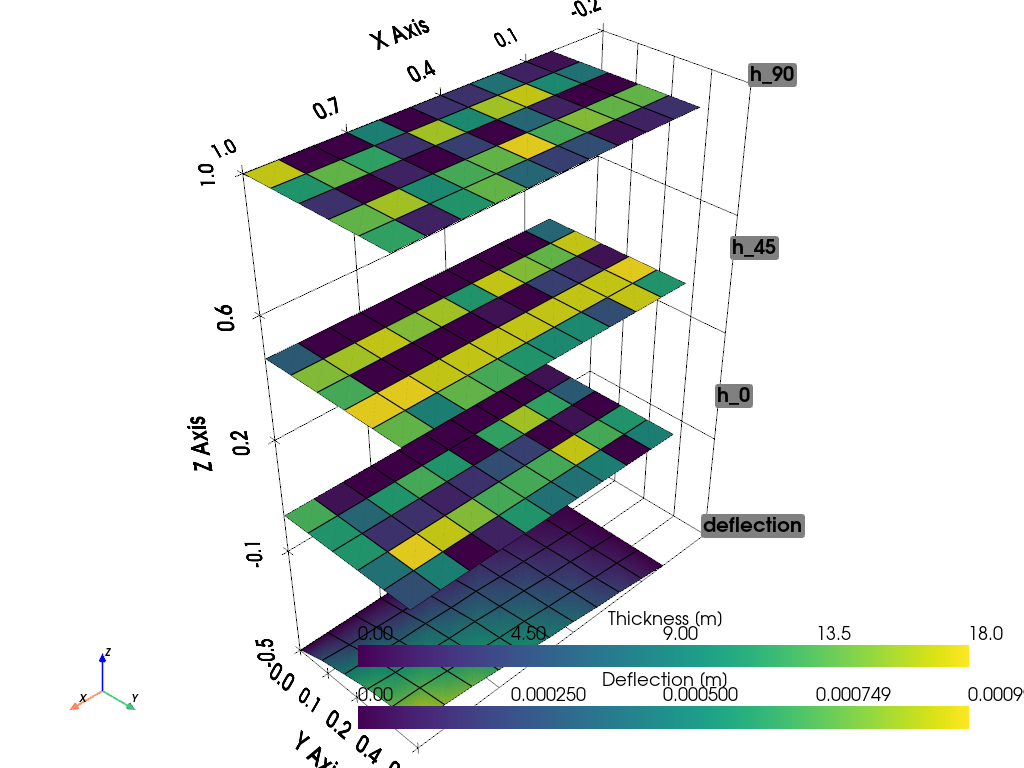

In [4]:
def plot_stacked_results(problem, history):
    """
    Plot the optimised thickness distributions for h0, h45, and h90
    as three stacked layers using PyVista.
    """
    # 1. Retrieve Geometry from the Problem Object
    ncoords = problem.ncoords

    # 2. Build Connectivity for PyVista
    # Determine the actual number of elements (quads) in the FE model
    n_elems = len(problem.quads)

    faces_quad = []
    for quad in problem.quads:
        # converting nid to index in the points array
        faces_quad.append([4, quad.n1 - 1, quad.n2 - 1, quad.n3 - 1, quad.n4 - 1])
    faces_quad = np.array(faces_quad)

    base_grid = pv.PolyData(ncoords, faces_quad)

    # 3. Extract Optimization Results
    x_best = history.best_X
    problem._evaluate(x_best, out={})

    # Slice the variables with stride 3, then TRUNCATE to match the number of elements
    # This discards the "ghost" variables created for the extra nodes
    h0_vals = x_best[0::3]
    h45_vals = x_best[1::3]
    h90_vals = x_best[2::3]

    # 4. Create Stacked Grids
    z_offset = min(problem.a, problem.b) * 0.5

    # --- Layer 0: deflection ---
    grid_w = base_grid.copy()
    grid_w.points[:, 2] -= z_offset
    grid_w.point_data["Deflection [m]"] = problem.result_w
    grid_w = grid_w.warp_by_scalar("Deflection [m]", factor=100.0)

    # --- Layer 1: 0 degrees ---
    grid_h0 = base_grid.copy()
    grid_h0.cell_data["Thickness [m]"] = h0_vals

    # --- Layer 2: +/- 45 degrees ---
    grid_h45 = base_grid.copy()
    grid_h45.points[:, 2] += z_offset
    grid_h45.cell_data["Thickness [m]"] = h45_vals

    # --- Layer 3: 90 degrees ---
    grid_h90 = base_grid.copy()
    grid_h90.points[:, 2] += 2 * z_offset
    grid_h90.cell_data["Thickness [m]"] = h90_vals

    plotter = pv.Plotter()
    cmap = "viridis"

    plotter.add_mesh(grid_w, scalars="Deflection [m]", cmap=cmap, show_edges=True)
    plotter.add_mesh(grid_h0, scalars="Thickness [m]", cmap=cmap, show_edges=True)
    plotter.add_mesh(grid_h45, scalars="Thickness [m]", cmap=cmap, show_edges=True)
    plotter.add_mesh(grid_h90, scalars="Thickness [m]", cmap=cmap, show_edges=True)

    label_x = -problem.a * 0.1
    label_y = problem.b / 2

    labels = ["deflection", "h_0", "h_45", "h_90"]
    label_coords = [
        [label_x, label_y, -z_offset],
        [label_x, label_y, 0],
        [label_x, label_y, z_offset],
        [label_x, label_y, 2 * z_offset]
    ]

    plotter.add_point_labels(
        label_coords,
        labels,
        font_size=20,
        point_size=0,
        text_color="black",
        always_visible=True
    )

    plotter.add_axes()
    plotter.show_grid()
    plotter.view_isometric()
    plotter.show(title="Optimized Thickness Distribution per Orientation")


plot_stacked_results(problem, history)